In [1]:
# Testing whether the projected LM approach works
#  Without the constraints, the problem admits both +x and -x as solutions.
# With the constraints, we should only get +x

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sopt.optimizers.tensorflow.lma import LMA

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
x_true = np.ones(20, dtype='float32') * 2

random_mat = np.random.randn(20,20)
A = random_mat @ random_mat

# The output data could be from x=2 or x=-2.
y = np.reshape(A @ x_true**2, [-1])

In [5]:
x_guess = np.random.randn(20).astype('float32') * 10

# LMA - linesearch for damping param

In [6]:
tf.reset_default_graph()

# x = 0 is also a stationary point. We are trying to avoid that by using clip_value_min > 0
constraint_fn = lambda x: tf.clip_by_value(x, clip_value_min=0.01, clip_value_max=2.1)
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

y_t = tf.constant(y, dtype='float32')
A_t = tf.constant(A, dtype='float32')                   
                   
x_true_t = tf.constant(x_true, dtype='float32', name='x_true')

def preds_fn(guess_var):
    return tf.reshape(A_t @ guess_var[:,None]**2, [-1])
def loss_fn(y_pred):
    return 0.5 * tf.reduce_sum((y_pred - y_t)**2)

In [7]:
preds_constr_t = preds_fn(var_constr)
loss_constr_t = loss_fn(preds_constr_t)
error_constr_t = tf.reduce_sum((var_constr - x_true_t)**2) / x_true.size

preds_unconstr_t = preds_fn(var_unconstr)
loss_unconstr_t = loss_fn(preds_unconstr_t)
error_unconstr_t = tf.reduce_sum((var_unconstr - x_true_t)**2)  / x_true.size

proj_lma_opt = LMA(var_constr, preds_fn, loss_fn, name='constr_opt', min_cg_tol=1e-1, assert_tolerances=False)
proj_lma_min_op = proj_lma_opt.minimize()

unconstr_lma_opt = LMA(var_unconstr, preds_fn, loss_fn, name='unconstr_opt', min_cg_tol=1e-1, assert_tolerances=False)
unconstr_lma_min_op = unconstr_lma_opt.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [8]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []
for i in range(100):
    session.run([proj_lma_min_op, unconstr_lma_min_op])
    l1, l2, e1, e2 = session.run([loss_constr_t, loss_unconstr_t, error_constr_t, error_unconstr_t])
    losses_constr.append(l1)
    errors_constr.append(e1)
    losses_unconstr.append(l2)
    errors_unconstr.append(e2)

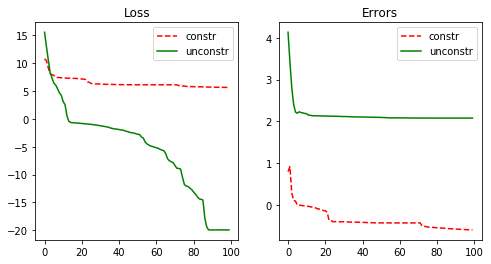

In [9]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(np.log(losses_constr), color='red', ls='--', label='constr')
plt.plot(np.log(losses_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(np.log(errors_constr), color='red', ls='--', label='constr')
plt.plot(np.log(errors_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [10]:
session.run([var_unconstr, var_constr])

[array([-1.9999926, -2.0000277,  2.0000062, -1.9999573,  2.0000196,
        -2.000033 , -1.9999732,  2.000034 ,  2.0000062,  2.0000367,
         2.0000265, -2.0000193,  1.999959 ,  1.9999427,  1.9999762,
        -2.0000572, -2.0000215, -1.9999843, -1.9999954,  1.9999617],
       dtype=float32),
 array([2.0046132 , 1.9797554 , 1.8781434 , 1.2175454 , 1.783487  ,
        1.8344574 , 1.7270534 , 0.5310961 , 1.9643551 , 2.040685  ,
        2.1       , 2.1       , 1.0864952 , 0.02972499, 2.1       ,
        0.18393902, 2.0817516 , 2.1       , 1.9597872 , 1.969658  ],
       dtype=float32)]

In [11]:
session.run([proj_lma_opt._iteration, proj_lma_opt._total_cg_iterations, proj_lma_opt._total_proj_ls_iterations]), session.run([unconstr_lma_opt._iteration, unconstr_lma_opt._total_cg_iterations])

([135, 1454, 146], [150, 2988])

In [12]:
session.run([error_constr_t, error_unconstr_t])

[0.55003375, 8.000025]

# LM without linesearch 

In [13]:
tf.reset_default_graph()

# x = 0 is also a stationary point. We are trying to avoid that by using clip_value_min > 0
constraint_fn = lambda x: tf.clip_by_value(x, clip_value_min=0.01, clip_value_max=2.1)
var_constr = tf.Variable(x_guess, dtype='float32', constraint=constraint_fn)
var_unconstr = tf.Variable(x_guess, dtype='float32')

y_t = tf.constant(y, dtype='float32')
A_t = tf.constant(A, dtype='float32')                   
                   
x_true_t = tf.constant(x_true, dtype='float32', name='x_true')

def preds_fn(guess_var):
    return tf.reshape(A_t @ guess_var[:,None]**2, [-1])
def loss_fn(y_pred):
    return 0.5 * tf.reduce_sum((y_pred - y_t)**2)

In [14]:
preds_constr_t = preds_fn(var_constr)
loss_constr_t = loss_fn(preds_constr_t)
error_constr_t = tf.reduce_sum((var_constr - x_true_t)**2) / x_true.size

preds_unconstr_t = preds_fn(var_unconstr)
loss_unconstr_t = loss_fn(preds_unconstr_t)
error_unconstr_t = tf.reduce_sum((var_unconstr - x_true_t)**2)  / x_true.size

proj_lma_opt = LMA(var_constr, preds_fn, loss_fn, name='constr_opt', min_cg_tol=1e-1, assert_tolerances=False, max_mu_linesearch_iters=1)
proj_lma_min_op = proj_lma_opt.minimize()

unconstr_lma_opt = LMA(var_unconstr, preds_fn, loss_fn, name='unconstr_opt', min_cg_tol=1e-1, assert_tolerances=False, max_mu_linesearch_iters=1)
unconstr_lma_min_op = unconstr_lma_opt.minimize()

session = tf.Session()
session.run(tf.global_variables_initializer())

In [15]:
losses_constr = []
errors_constr = []
losses_unconstr = []
errors_unconstr = []
for i in range(100):
    session.run([proj_lma_min_op, unconstr_lma_min_op])
    l1, l2, e1, e2 = session.run([loss_constr_t, loss_unconstr_t, error_constr_t, error_unconstr_t])
    losses_constr.append(l1)
    errors_constr.append(e1)
    losses_unconstr.append(l2)
    errors_unconstr.append(e2)

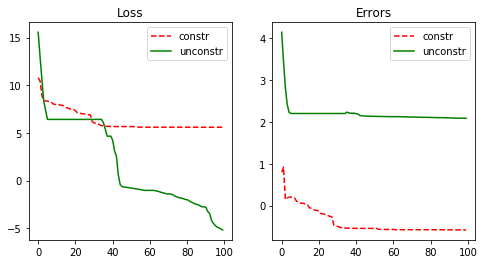

In [16]:

plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(np.log(losses_constr), color='red', ls='--', label='constr')
plt.plot(np.log(losses_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(np.log(errors_constr), color='red', ls='--', label='constr')
plt.plot(np.log(errors_unconstr), color='green', label='unconstr')
plt.legend(loc='best')
plt.title('Errors')
plt.show()

In [17]:
session.run([var_unconstr, var_constr])

[array([-1.9857541, -2.0556927,  2.0112402, -1.9227211,  2.0343132,
        -2.050549 , -1.953015 ,  2.0615304,  2.014216 ,  2.0623436,
         2.0421526, -2.0320904,  1.9341441,  1.9026878,  1.9633642,
        -2.0992885, -2.029112 , -1.9630085, -1.9912575,  1.9363899],
       dtype=float32),
 array([2.0998156 , 2.0968685 , 1.7130423 , 1.2153122 , 2.070712  ,
        2.1       , 1.495485  , 0.68724823, 2.059907  , 2.0654778 ,
        2.1       , 2.0352485 , 0.03199795, 0.02103464, 2.1       ,
        1.2437457 , 2.1       , 2.0968256 , 1.8814751 , 1.7258608 ],
       dtype=float32)]

In [18]:
session.run([proj_lma_opt._iteration, proj_lma_opt._total_cg_iterations, proj_lma_opt._total_proj_ls_iterations]), session.run([unconstr_lma_opt._iteration, unconstr_lma_opt._total_cg_iterations])

([100, 1200, 141], [100, 1862])